In [1]:
from analysis_utils import top_activations, extract_features, prompt_search_mean_local, prompt_search_rank, influence, cosine_similarity_search
from plot_utils import examples_plot_df, examples_plot_df_horizontal, examples_plot_anthropic, plot_UMAP
from autoencoder import SparseAutoencoder

2025-03-04 15:40:28.029341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741099228.117637    6286 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741099228.143762    6286 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 15:40:28.372933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
import json
import glob
import torch
import numpy as np

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

## Get example from the dataset and feature activations
(only needs the tokenizer)

In [4]:
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
indicies = [13925, 25643, 29442, 48756,   978, 25743, 47793, 64695, 32209,
        28549, 63685,  2363, 40475,   232, 17897,
        5713, 65117, 45017,    59863,  5805, 55509,  6300, 21018,
        53514,  2638, 54457, 13321, 47821]

top_examples = top_activations(
    feat_idx_list=indicies, 
    k=20, 
    context_len=15, 
    latent_dataset_path="../sparse_latent_vectors/latent_vectors_batch_*.pt", 
    dataset_slice=(0,50), 
    act_id_dataset="../activations_data/last3_batch_*.npy", 
    tokenizer=tokenizer, 
    # verbose=True
)



Top 20 activations for feature index 13925 across all files:
File: ../sparse_latent_vectors/latent_vectors_batch_0_minibatch_17.pt
Target token: ' before'
Activation value: 2.28286075592041
Context:  Gilboe started her career in musical theatre and operas in Aarhus before she moved to Copenhagen to work at different theatres. Her national breakthrough came

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_4.pt
Target token: 'oh'
Activation value: 2.0139806270599365
Context: with some other color along with dimensions will certainly suit most of the people’ohydrates flavor. most of us list all of those goods available on

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_11.pt
Target token: ' off'
Activation value: 1.9023239612579346
Context:  a class on the “religion of peace”)“F**k off! It’s enough that I have to see you shit-kickers every day

File: ../sparse_latent_vectors/latent_vectors_batch_0_minibatch_17.pt
Target token: ' she'
Activation value: 1.8

In [19]:
examples_plot_df(top_examples[40171][1]) # Plots the top example for feature 58517

,Token,Activation
0,that,0.973863
1,Â´s,0.006733
2,what,1.229521
3,hurts,0.000000
4,We,0.402182
5,Â´,0.000000
6,re,0.817693
7,so,0.754490
8,close,0.364640
9,to,0.493131


In [11]:
examples_plot_df_horizontal(top_examples[53475][0])

,savings_0,engineers_1,have_2,realized_3,from_4,their_5,use_6,of_7,engineering_8,software_9,.ĊĊ_10,In_11,Cam_12,ber_13,ly_14,",_15",U_16,.K_17,".,_18",the_19,design_20,team_21,at_22,res_23,eller_24,Williams_25,Medical_26,Supplies_27,set_28,up_29,a_30
Activation,0.000000,0.150668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157078,0.000000,0.454832,0.557851,0.440254,3.300996,1.395883,0.000000,0.705596,1.147092,0.200662,0.071207,0.255687,0.000000,0.000000,0.607593,0.003500,0.390689,0.000000,0.000000,0.000000


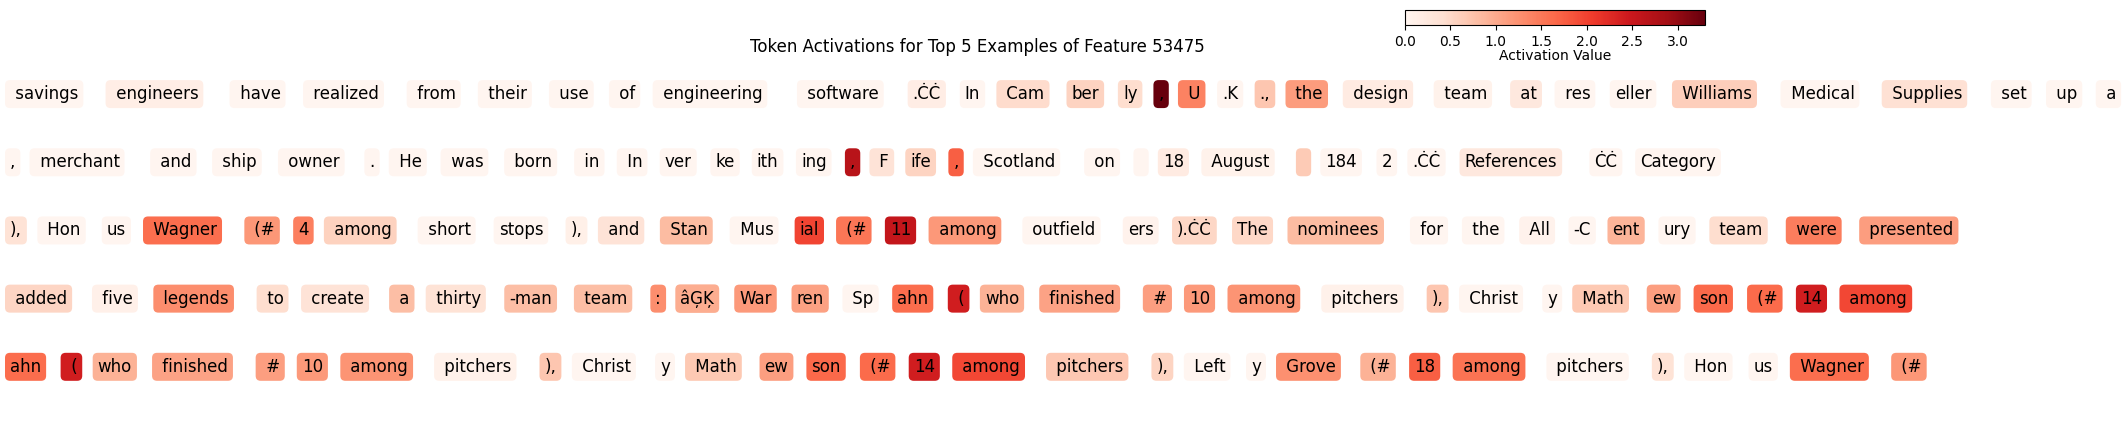

In [12]:
feat_idx = 53475
top5_examples = {}
top5_examples[feat_idx] = {}
for i in range(5): # slice top 5
    top5_examples[feat_idx][i] = top_examples[feat_idx][i]

examples_plot_anthropic(feat_idx, top5_examples[feat_idx], save_path=None)

## Feature auto-interpretation
(requires the instruct model)

In [3]:
prompt = """
You are analyzing the top activations of sparse features from a latent vector model. Each feature corresponds to a specific linguistic or contextual pattern in the data. For each feature:

    Identify the dominant tokens that consistently have the highest activation scores. Disregard outliers or anomalies unless they are part of a recurring pattern.
    Describe the common patterns or contexts in which the feature activates. Focus on linguistic structures, document types, or thematic styles.
    Summarize the feature by capturing its primary function or what it detects in the text. Be concise but specific.
    If a feature activates only in specific types of content (e.g., Wikipedia articles, code snippets, financial documents), highlight this specificity.

Output format:

    Feature Index [X]:
        Dominant Tokens: [list of tokens]
        Patterns: [description of contexts or structures]
        Summary: [clear and specific feature description]
        Context: [destinctive pattern only looking at context]
        Title: [short identifying phrase]

Ensure that each summary is accurate, avoids overgeneralization, and captures patterns meaningful for downstream analysis. Keep it short.

Sometimes its just the word (word 'the' in any context), sometimes it is a specific context it appears in (appears in wiki articles), sometimes its structual element (start of sentence), sometimes its a combination. Find the commnalities/the pattern in the examples provided for a specific feature.
Note that sometimes there might me anomalies among the examples.
Write it out in simple terms, so anyone can understand.

The Context should be generated by just taking the context, and you don't know the token where the feature activates, just by looking at the sentences, what can we deduce.
For the Title: with one phrase (3 words or less) describe this feature, you must give a very specific concept that applys to these sentences, and the phrase must be on 10th grader level. The title should be as specific as possible (ie "health study participants" not "medical")
"""
examples = """

Top 20 activations for feature index 28947 across all files:
File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_15.pt
Target token: ' lovely'
Activation value: 4.399613380432129
Context:  Oh La La CD Carnival of Colours which has some beautiful images and is lovely to use especially when you need a quick card.For part of the background I

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_15.pt
Target token: ' wonderful'
Activation value: 4.115923881530762
Context:  lovely day.....Saturday, 17 March 2012She's a wonderful daughter and a fantastic mum. Martin her husband is taking her away for a

File: ../sparse_latent_vectors/latent_vectors_batch_0_minibatch_14.pt
Target token: ' loved'
Activation value: 4.059423446655273
Context:  but that we all know aren't the way the world works.I really loved that about it. It's going to be one of my comfort books,

File: ../sparse_latent_vectors/latent_vectors_batch_2_minibatch_17.pt
Target token: ' fabulous'
Activation value: 3.950557231903076
Context:  Bill Shorten, at a rally in Melbourne, said: “What a fabulous time to be an Australian – because in this survey the Australian population has stated

File: ../sparse_latent_vectors/latent_vectors_batch_0_minibatch_14.pt
Target token: ' nice'
Activation value: 3.933279275894165
Context:  it doesn't call life as we know it into question.It's a nice read/listen, light and intriguing for anyone in the mood for a little

File: ../sparse_latent_vectors/latent_vectors_batch_0_minibatch_14.pt
Target token: ' perfect'
Activation value: 3.8555078506469727
Context:  enjoy that. And then the author lays it all out and it's just perfect. A little too perfect, like in one of those rom-coms that

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_15.pt
Target token: ' lovely'
Activation value: 3.7567996978759766
Context:  looking after the children, we are having a family meal today which will be lovely...Friday, 16 March 2012I love these sets where

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_10.pt
Target token: ' great'
Activation value: 3.7131521701812744
Context:  will be reviewed by acommittee of established production companies. This is a great way to getexposure and even discovered in Hollywood.The festival is

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_1.pt
Target token: ' great'
Activation value: 3.632704734802246
Context:  Bank of Internet online savings account has no maintenance fees, so it’s a great opportunity to earn a high interest rate with a free online bank account.There

File: ../sparse_latent_vectors/latent_vectors_batch_0_minibatch_14.pt
Target token: ' read'
Activation value: 3.6271486282348633
Context:  doesn't call life as we know it into question.It's a nice read/listen, light and intriguing for anyone in the mood for a little escape

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_4.pt
Target token: ' wonderful'
Activation value: 3.605731725692749
Context:  at the activity center holding a fresh bouquet for Susy. It was a wonderful day for Susy and Geno and for their solid fans club. After

File: ../sparse_latent_vectors/latent_vectors_batch_2_minibatch_10.pt
Target token: ' amazing'
Activation value: 3.5959033966064453
Context:  Parenthood Action Fund President Cecile Richards will be in town. She’s an amazing progressive leader, fighting every day for women’s health care on the national level

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_17.pt
Target token: 'Awesome'
Activation value: 3.5071704387664795
Context: avatars/DonSleza4e.jpgmessage: <p>Awesome<br>Integrated lib with my <a href="http://asp.net"

File: ../sparse_latent_vectors/latent_vectors_batch_2_minibatch_11.pt
Target token: ' wonderful'
Activation value: 3.3908119201660156
Context:  walls fluttered around it as he slid in, balls deep. It felt wonderful, and he could feel Cathy’s flesh spread while at the same time she

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_15.pt
Target token: ' to'
Activation value: 3.331742763519287
Context:  La La CD Carnival of Colours which has some beautiful images and is lovely to use especially when you need a quick card.For part of the background I have

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_6.pt
Target token: ' fantastic'
Activation value: 3.3278238773345947
Context:  Apr 17, 2014 8:54 amFormat is fantastic

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_17.pt
Target token: ' Great'
Activation value: 3.2627060413360596
Context: Work Would be Great Without the CoworkersThe French philosopher Jean-Paul Satre once

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_11.pt
Target token: ' great'
Activation value: 3.253603219985962
Context:  first act of a crime thriller along the same lines as Red Dragon (a great movie that should be seen if you haven’t already). This provides the audience

File: ../sparse_latent_vectors/latent_vectors_batch_0_minibatch_14.pt
Target token: ' perfect'
Activation value: 3.2163166999816895
Context:  that ripped your heart out (like I have recently), than this is the perfect book to recover with. It's comforting and sweet and romantic and doesn't

File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_14.pt
Target token: ' good'
Activation value: 3.2104334831237793
Context:  deserved. I am rich in spirit, health and family. God has been good to that little boy from long ago, enabling me to do something I love

"""

x = prompt + examples

In [ ]:
# Model and tokenizer setup
model_name_i = "meta-llama/Llama-3.2-3B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer_i = AutoTokenizer.from_pretrained(model_name_i, cache_dir="../models/llama_local_i")
tokenizer_i.pad_token = tokenizer_i.eos_token

bnb_config_i = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model_instruct = AutoModelForCausalLM.from_pretrained(model_name_i, quantization_config=bnb_config_i, cache_dir="../models/llama_local_i")


tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
input_text = "Instruction: " + prompt + "  Examples: " + examples + "Do not repeat the examples. \n ### Answer:"

inputs = tokenizer_i(input_text, return_tensors="pt")
model_outputs = model_instruct.generate(**inputs, max_new_tokens=120, return_dict_in_generate=True, output_scores=True)
generated_tokens_ids = model_outputs.sequences[0]
out_txt = tokenizer_i.decode(generated_tokens_ids)

out_txt = out_txt.split("### Answer:")[-1]
print(out_txt)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


 
## Feature Index 28947:
Dominant Tokens: ['lovely', 'loving', 'to']
Patterns: The feature activates in contexts that involve appreciation, admiration, or sentimentality, often in conjunction with expressions of affection or love.
Summary: This feature detects positive sentiment and affectionate language.
Context: Sentimental or affectionate contexts.
Title: "Admiring Love"

## Feature Index 28948:
Dominant Tokens: ['wonderful', 'loving', 'great']
Patterns: The feature activates in contexts that express admiration, appreciation, or enthusiasm, often


## Searching for specific features

In [4]:
# Model and tokenizer setup
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)

# Load the sparse autoencoder model and weights
input_dim = 3072
hidden_dim = 2 ** 16 # 65536
model_sae = SparseAutoencoder(input_dim, hidden_dim)
model_sae.load_state_dict(torch.load("../models/sparse_autoencoder_65kbest.pth"))
# checkpoint = torch.load("../models/checkpoint", weights_only=True)
# model_sae.load_state_dict(checkpoint['state_dict'])
# model_sae.eval()


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_6286/3444118019.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_sae.load_state_dict(torch.load("../models/sparse_autoencoder_65kbest.pth"))


<All keys matched successfully>

### (medical) language comparison
(do the same medical features activate in different languages?)

In [5]:
test_sent_eng = "Proportion of different immune cell subsets were detected in the peripheral blood of 124 ITP patients at different time points and 45 normal controls by flow"
test_sent_esp = "Se detectaron proporciones de diferentes subconjuntos de células inmunes en la sangre periférica de 124 pacientes con PTI en diferentes momentos y 45 controles normales por citometría de flujo"
feat_idx = 45783
tokens1, latent_vec1, _ = extract_features([test_sent_eng], [], tokenizer, model, model_sae)
tokens2, latent_vec2, _ = extract_features([test_sent_esp], [], tokenizer, model, model_sae)

e1 = {"token_list": tokens1, "activations": latent_vec1[:,feat_idx]}
e2 = {"token_list": tokens2, "activations": latent_vec2[:,feat_idx]}
# plot/print
examples_plot_df_horizontal(e1)
examples_plot_df_horizontal(e2)


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


,Pro_0,portion_1,of_2,different_3,immune_4,cell_5,subsets_6,were_7,detected_8,in_9,the_10,peripheral_11,blood_12,of_13,_14,124_15,I_16,TP_17,patients_18,at_19,different_20,time_21,points_22,and_23,_24,45_25,normal_26,controls_27,by_28,flow_29
Activation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129902,0.004995,0.346946,0.175778,0.105497,0.270528,0.760727,1.653711,1.814199,0.345634,0.515723,1.829130,1.557498,1.019142,1.048449,1.142285,1.158589,1.450190,1.394830,1.340168,1.406348,0.194270,0.000000


,Se_0,detect_1,aron_2,prop_3,orc_4,iones_5,de_6,diferentes_7,sub_8,conj_9,untos_10,de_11,cÃ©l_12,ulas_13,in_14,m_15,unes_16,en_17,la_18,sang_19,re_20,per_21,if_22,Ã©rica_23,de_24,_25,124_26,pacientes_27,con_28,PT_29,I_30,en_31,diferentes_32,momentos_33
Activation,0.000000,0.000000,0.115228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139247,0.026156,0.000000,0.093849,0.084543,0.000000,0.079534,0.344302,1.183564,1.515277,1.296967,0.448045,0.000000,0.105981,1.235367,0.902711,0.895968


In [32]:
feat_idx = 46745
e1 = {"token_list": tokens1, "activations": latent_vec1[:,feat_idx]}
e2 = {"token_list": tokens2, "activations": latent_vec2[:,feat_idx]}
# plot/print
examples_plot_df_horizontal(e1)
examples_plot_df_horizontal(e2)

,Pro_0,portion_1,of_2,different_3,immune_4,cell_5,subsets_6,were_7,detected_8,in_9,the_10,peripheral_11,blood_12,of_13,_14,124_15,I_16,TP_17,patients_18,at_19,different_20,time_21,points_22,and_23,_24,45_25,normal_26,controls_27,by_28,flow_29
Activation,0.000000,0.000000,0.001640,0.208738,0.125617,0.092319,0.146297,0.107951,0.267589,0.120035,0.108379,0.000000,0.070899,0.276318,0.217051,0.266311,0.176073,0.000000,0.115860,0.293588,0.212862,0.008646,0.166180,0.054385,0.231065,0.091412,0.155598,0.083615,0.036931,0.000000


,Se_0,detect_1,aron_2,prop_3,orc_4,iones_5,de_6,diferentes_7,sub_8,conj_9,untos_10,de_11,cÃ©l_12,ulas_13,in_14,m_15,unes_16,en_17,la_18,sang_19,re_20,per_21,if_22,Ã©rica_23,de_24,_25,124_26,pacientes_27,con_28,PT_29,I_30,en_31,diferentes_32,momentos_33
Activation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052343,0.000000,0.000000,0.000000,0.043347,0.000000,0.000000,0.173655,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120324,0.007642,0.146327,0.156529,0.121731,0.000000,0.051767,0.037680,0.164225,0.071806


In [33]:
feat_idx = 63789
e1 = {"token_list": tokens1, "activations": latent_vec1[:,feat_idx]}
e2 = {"token_list": tokens2, "activations": latent_vec2[:,feat_idx]}
# plot/print
examples_plot_df_horizontal(e1)
examples_plot_df_horizontal(e2)

,Pro_0,portion_1,of_2,different_3,immune_4,cell_5,subsets_6,were_7,detected_8,in_9,the_10,peripheral_11,blood_12,of_13,_14,124_15,I_16,TP_17,patients_18,at_19,different_20,time_21,points_22,and_23,_24,45_25,normal_26,controls_27,by_28,flow_29
Activation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062014,0.193627,1.233625,1.037814,0.247218,0.634012,1.512894,1.340979,1.340204,0.476144,0.660637,1.505079,1.156014,0.926543,0.809139,0.946725,0.981318,1.298201,1.428196,1.437053,1.331901,0.000000,0.070610


,Se_0,detect_1,aron_2,prop_3,orc_4,iones_5,de_6,diferentes_7,sub_8,conj_9,untos_10,de_11,cÃ©l_12,ulas_13,in_14,m_15,unes_16,en_17,la_18,sang_19,re_20,per_21,if_22,Ã©rica_23,de_24,_25,124_26,pacientes_27,con_28,PT_29,I_30,en_31,diferentes_32,momentos_33
Activation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044167,0.005586,0.043861,0.000000,0.000000,0.116952,0.009495,0.000000,0.631525,0.713609,0.196601,0.579217,0.375403,0.043946,0.321647,0.910568,0.846159,1.015892,0.947796,0.463676,0.163957,0.351116,1.113733,0.979740,0.643968


In [24]:
# Positive prompts 
pos_prompts = [
    "Proportion of different immune cell subsets were detected in the peripheral blood of 124 ITP patients at different time points and 45 normal controls by flow"
]
pos_prompts3 = [
    # "Se detectaron proporciones de diferentes subconjuntos de células inmunes en la sangre periférica de 124 pacientes con PTI en diferentes momentos y 45 controles normales por citometría de flujo"
    "La proporción de diferentes subconjuntos de células inmunitarias se detectó en la sangre periférica de 124 pacientes con ITP en diferentes momentos y 45 controles normales mediante citometría de flujo."
]

# Negative prompts 
neg_prompts = [
    # sentence starters
    "The proportion of different",
    "A wild animal was spotted",
    "If two people are from Norway, and there is noone else from Norway, then",
]

top_k_indices1, top_k_values1 = prompt_search_mean_local(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=False)
# top_k_indices2, top_k_value2s = prompt_search_rank(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)
top_k_indices3, top_k_values3 = prompt_search_mean_local(pos_prompts3, neg_prompts, 15, tokenizer, model, model_sae, verbose=False)

# print side by side
for i in range(15):
    print(f"{top_k_indices1[i]} : {top_k_indices3[i]}")

46745 : 17024
63789 : 26932
29327 : 53801
23644 : 15450
416 : 14817
15742 : 37573
17384 : 27243
43725 : 48621
32455 : 13680
40295 : 28174
3022 : 37785
19285 : 40429
8753 : 60362
29230 : 31506
27250 : 33891


In [ ]:
# 46745 Medical study findings      : 17024 Structured Collectives
# 63789 Clinical experiment details : 26932 Comparing Differences
# 29327 Disease terminology         : 53801 Seeking Advice
# 23644 Programming questions       : 15450 Formal Research Terms
# 416 Medical diagnosis terms       : 14817 Numbered Instructions
# 15742 Software identifiers        : 37573 Anatomy & Medicine
# 17384 Automated processes         : 27243 Genetic Deficiencies
# 43725 Clinical study results      : 48621 Programming Concepts
# 32455 Health & safety terms       : 13680 Linked Concepts
# 40295 Proper names & brands       : 28174 Personal Transitions
# 3022 Technical concepts           : 37785 Statistical Measures
# 19285 Medical statistics          : 40429 Legal & Emotional Language
# 8753 Scientific measurements      : 60362 Structured Data & Time
# 29230 Code annotations            : 31506 Medical & Legal Terms
# 27250 General categories          : 33891 Time Stamps & Scheduling


In [30]:
list(top_k_indices1) + list(top_k_indices3)

[46745,
 63789,
 29327,
 23644,
 416,
 15742,
 17384,
 43725,
 32455,
 40295,
 3022,
 19285,
 8753,
 29230,
 27250,
 17024,
 26932,
 53801,
 15450,
 14817,
 37573,
 27243,
 48621,
 13680,
 28174,
 37785,
 40429,
 60362,
 31506,
 33891]

In [10]:
eng_txt = [
    "program on aerobic capacity and muscle strength of adults with hearing loss. Twenty-three adults with hearing loss were separated into 2 groups. Thirteen subjects",
    "the effect of a traditional dance training program on aerobic capacity and muscle strength of adults with hearing loss. Twenty-three adults with hearing loss were separated into",
    "been examined comprehensively. Peritoneal lavage was performed in 351 patients before curative resection of a gastric carcinoma between 1987 and"
]
# top mean index english = tmie
tmie, tmve = prompt_search_mean_local(eng_txt, [], 100, tokenizer, model, model_sae, verbose=False)
trie, trve = prompt_search_rank(eng_txt, [], 100, tokenizer, model, model_sae, verbose=False)


esp_txt = [
    "programa sobre la capacidad aeróbica y la fuerza muscular de adultos con pérdida de audición. Veintitrés adultos con pérdida de audición fueron separados en 2 grupos. Trece sujetos",
    "el efecto de un programa de entrenamiento de danza tradicional en la capacidad aeróbica y la fuerza muscular de adultos con pérdida de audición. Veintitrés adultos con pérdida de audición fueron separados en",
    "examinado exhaustivamente. Se realizó lavado peritoneal en 351 pacientes antes de la resección curativa de un carcinoma gástrico entre 1987 y"
]
tmis, tmvs = prompt_search_mean_local(esp_txt, [], 100, tokenizer, model, model_sae, verbose=False)
tris, trvs = prompt_search_rank(esp_txt, [], 100, tokenizer, model, model_sae, verbose=False)

# calculate IoU of the top k indices Eglish VS Spanish
intersection = len(set(tmie).intersection(set(tmis)))
union = len(set(tmie).union(set(tmis)))
iou = intersection / union
print(f"IoU of top mean indices: {iou}")

intersection = len(set(trie).intersection(set(tris)))
union = len(set(trie).union(set(tris)))
iou = intersection / union
print(f"IoU of top rank indices: {iou}")


IoU of top mean indices: 0.06382978723404255
IoU of top rank indices: 0.15606936416184972


In [11]:
tmis[:15]

array([57660,  9660,   659, 13943, 58632, 45822, 44589, 55779, 27389,
       18412, 33304, 64499, 33140, 25334, 10562])

In [22]:
(set(tmie).intersection(set(tmis)))

{3189,
 9660,
 9720,
 10562,
 24098,
 31476,
 32026,
 34366,
 46445,
 54693,
 55507,
 57660}

In [19]:
sr = set(trie).intersection(set(tris))
for i in tris:
    if i in sr:
        print(i)

52875
9660
20291
32026
6527
55507
64499
10562
61838
50567
4581
13310
21815
46445
14701
9720
43574
23139
47097
14171
52423
29815
44611
60332
6641
52757
41517


In [ ]:
# 6527  Population Studies
# 55507 Formal Explanations
# 64499 Scientific Terminology
# 10562 Online references
# 61838 Medical Study Results
# 50567 Medical Paper Titles
# 4581  Sentence Starters
# 13310 Scientific Terms
# 21815 Comparative Descriptions
# 46445 Business & Finance Terms
# 14701 Quantitative Demographics
# 9720  Multilingual entities
# 43574 Medical Patient Data
# 23139 Women's Health Studies
# 47097 Section headers
# 14171 Sentence Starters
# 52423 Programming Syntax
# 29815 Uppercase Initials
# 44611 Scientific Measurements
# 60332 Study Impact Analysis
# 6641  Legal case roles
# 52757 Medical Study Terms
# 41517 Experiment Validation

# 52875 Sentence Starters
# 9660  Article Intros
# 20291 Sentence Starters
# 32026 Scientific Study Purpose

In [ ]:
#Feature 9720: 0.0018- Multilingual Entities
#Feature 10562: 74- Online References
#Feature 57660: 0.2853- Academic References


# Feature 6527: 0.2511 + Population Studies
# Feature 13310: 0.3060 - Scientific Terms
# Feature 32026: 0.2996- Scientific Study Purpose

# Feature 52875: 0.0136- Title Sentence Starters
# Feature 9660: 84- Sentence Starters
# Feature 4581: 0.0208- Sentence Starters



#### language (spanish) feature

In [15]:
# Positive prompts (spanish)
pos_prompts = [
    "El sol brilla intensamente en el cielo azul.",
    "Ayer fuimos a la playa y jugamos al voleibol.",
    "Me gusta mucho el café con leche por las mañanas.",
    "El perro corre felizmente por el parque.",
    "Aprender un nuevo idioma puede ser muy divertido."
]

# Negative prompts 
# neg_prompts = [
#     "The environment minister, Emmanuel Niyonkuru has been killed by an unknown gunman",
#     "The effects of turbulent jet flows on plant cell suspension culturesCell suspensions of",
#     "The Hottest NBA Trade Rumors provided daily. Blazers preparing offer for Utah's Paul Mills",
#     "Q:Google Maps Android API v2 - for ARM only? Google Maps Android API v2"
# ]

neg_prompts = [
    "The sun shines brightly in the blue sky.",
    "Yesterday we went to the beach and played volleyball.",
    "I really like coffee with milk in the mornings.",
    "The dog runs happily through the park.",
    "Learning a new language can be a lot of fun."
]

top_k_indices1, top_k_values1 = prompt_search_mean_local(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)
top_k_indices2, top_k_values2 = prompt_search_rank(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)


Top 15 features and their mean activation values:
Feature 5701: 0.2846
Feature 34499: 0.2365
Feature 5558: 0.2191
Feature 6164: 0.2175
Feature 23057: 0.2148
Feature 12087: 0.2124
Feature 24268: 0.2098
Feature 6494: 0.2092
Feature 50959: 0.2083
Feature 34016: 0.2069
Feature 13943: 0.2055
Feature 41537: 0.2037
Feature 35579: 0.2021
Feature 46877: 0.1993
Feature 53: 0.1985
Top 15 features and their scores:
Feature 5558 => pos_freq=0.6212, neg_freq=0.0417, score=0.5795
Feature 5701 => pos_freq=0.6364, neg_freq=0.0833, score=0.5530
Feature 35579 => pos_freq=0.5758, neg_freq=0.0417, score=0.5341
Feature 60373 => pos_freq=0.5758, neg_freq=0.0417, score=0.5341
Feature 13943 => pos_freq=0.4545, neg_freq=0.0208, score=0.4337
Feature 12087 => pos_freq=0.4697, neg_freq=0.0625, score=0.4072
Feature 34499 => pos_freq=0.5303, neg_freq=0.1250, score=0.4053
Feature 32211 => pos_freq=0.3939, neg_freq=0.0000, score=0.3939
Feature 14319 => pos_freq=0.6212, neg_freq=0.2292, score=0.3920
Feature 25334 => po

In [16]:
(top_k_indices1, top_k_indices2)

(array([ 5701, 34499,  5558,  6164, 23057, 12087, 24268,  6494, 50959,
        34016, 13943, 41537, 35579, 46877,    53]),
 array([ 5558,  5701, 35579, 60373, 13943, 12087, 34499, 32211, 14319,
        25334, 54986, 11801, 29831, 45959, 65439]))

In [ ]:
# 23057 - Spanish(/Portuguese) phrases
# 11801 - Spanish Writing & Instructions

### humor / sarcasm / funny
(did not find any)

In [19]:
# funny humor sarcasm
pos_prompts = [
    "I'm not arguing, I'm just explaining why I'm right.",
    "Some people graduate with honors, I am just honored to graduate.",
    "I'd agree with you, but then we'd both be wrong.",
    "My bed and I have a special relationship - we're perfect for each other, but my alarm clock keeps trying to break us up.",
    "Exercise? I thought you said extra fries!"
]
neg_prompts = [ # serious/factual
    "Water boils at 100 degrees Celsius at sea level.",
    "The speed of light in a vacuum is approximately 299,792,458 meters per second.",
    "The human brain contains approximately 86 billion neurons.",
    "Earth's atmosphere is composed of roughly 78 percent nitrogen and 21 percent oxygen.",
]

top_k_indices1, top_k_values1 = prompt_search_mean_local(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)
top_k_indices2, top_k_values2 = prompt_search_rank(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)

Top 15 features and their mean activation values:
Feature 13925: 0.2788
Feature 25643: 0.2333
Feature 29442: 0.2278
Feature 48756: 0.2250
Feature 978: 0.2163
Feature 25743: 0.2149
Feature 47793: 0.2144
Feature 64695: 0.2141
Feature 32209: 0.2092
Feature 28549: 0.2077
Feature 63685: 0.2036
Feature 2363: 0.2013
Feature 40475: 0.1996
Feature 232: 0.1996
Feature 17897: 0.1969
Top 15 features and their scores:
Feature 5713 => pos_freq=0.5844, neg_freq=0.0000, score=0.5844
Feature 65117 => pos_freq=0.6104, neg_freq=0.0526, score=0.5578
Feature 45017 => pos_freq=0.5065, neg_freq=0.0175, score=0.4889
Feature 978 => pos_freq=0.5065, neg_freq=0.0175, score=0.4889
Feature 59863 => pos_freq=0.4675, neg_freq=0.0000, score=0.4675
Feature 5805 => pos_freq=0.4805, neg_freq=0.0175, score=0.4630
Feature 55509 => pos_freq=0.4286, neg_freq=0.0000, score=0.4286
Feature 6300 => pos_freq=0.4416, neg_freq=0.0175, score=0.4240
Feature 21018 => pos_freq=0.4416, neg_freq=0.0175, score=0.4240
Feature 53514 => pos

In [20]:
(top_k_indices1, top_k_indices2)

(array([13925, 25643, 29442, 48756,   978, 25743, 47793, 64695, 32209,
        28549, 63685,  2363, 40475,   232, 17897]),
 array([ 5713, 65117, 45017,   978, 59863,  5805, 55509,  6300, 21018,
        53514, 64695,  2638, 54457, 13321, 47821]))

### emotion 

In [45]:
# Positive prompts (emotional expressions)
pos_prompts = [
    "can't believe this is happening",  # Excitement (cut-off phrase)
    "so unfair, why does it always happen to me",  # Frustration (casual complaint)
    "regret to inform you that your application has been unsuccessful",  # Sadness (formal notification)
    "just sitting here, watching the rain fall",  # Melancholy (contemplative)
    "breath quickens, heart pounding, footsteps behind me",  # Fear (suspenseful fragment)
    "warm embrace, whispered words, everything felt right",  # Love (sensory details)
    "if only I had said something",  # Guilt (unfinished thought)
    "ugh, the smell, I can't",  # Disgust (casual reaction)
    "and just like that, all hope was gone",  # Despair (story-like phrasing)
    "this is the best day of my life",  # Happiness (exclamation removed)
    "he was feeling on top of the world, this was the happiest day of his life"
]

# Negative prompts (factual/objective statements)
neg_prompts = [ 
    "the sky is blue",
    "today the building collapsed",
    "343 people lost their jobs, due to the company going bankrupt",
    "The average human life span is 79 years.",
    "The capital of France is Paris.",
    "Who will be the next president of the United States?",
]

top_k_indices, top_k_values = prompt_search_mean_local(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)
top_k_indices, top_k_values = prompt_search_rank(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)


Top 15 features and their mean activation values:
Feature 59589: 0.2044
Feature 15083: 0.2021
Feature 19848: 0.2019
Feature 28332: 0.1851
Feature 3444: 0.1792
Feature 62048: 0.1778
Feature 1476: 0.1759
Feature 46564: 0.1733
Feature 9660: 0.1710
Feature 61617: 0.1700
Feature 4421: 0.1673
Feature 55712: 0.1641
Feature 29537: 0.1633
Feature 7533: 0.1611
Feature 31551: 0.1609
Top 15 features and their scores:
Feature 33330 => pos_freq=0.5243, neg_freq=0.1250, score=0.3993
Feature 53667 => pos_freq=0.3981, neg_freq=0.0000, score=0.3981
Feature 29537 => pos_freq=0.4951, neg_freq=0.1042, score=0.3910
Feature 65117 => pos_freq=0.4466, neg_freq=0.0625, score=0.3841
Feature 28333 => pos_freq=0.5049, neg_freq=0.1250, score=0.3799
Feature 28947 => pos_freq=0.4078, neg_freq=0.0417, score=0.3661
Feature 13321 => pos_freq=0.3981, neg_freq=0.0417, score=0.3564
Feature 8538 => pos_freq=0.3689, neg_freq=0.0208, score=0.3481
Feature 13654 => pos_freq=0.6117, neg_freq=0.2708, score=0.3408
Feature 18980 =>

In [52]:
#Can't find features for bad emotions
# Positive prompts (bad emotions and feelings: sadness, anger, fear, disgust, guilt)
pos_prompts = [
    "can't believe this is happening to me",  # Sadness (casual complaint)
    "so unfair, why does it always happen to me",  # Anger (casual complaint)
    # "regret to inform you that your application has been unsuccessful",  # Sadness (formal notification)
    "just sitting here, watching the rain fall",  # Melancholy (contemplative)
    "breath quickens, heart pounding, footsteps behind me",  # Fear (suspenseful fragment)
    # very angry
    "I am so angry right now, how could she cheat on me like that",
    "This is the last straw, I can't take it anymore",
]

# Negative prompts (factual/objective statements)
neg_prompts = [ 
    "This is the start of a sentence.",
    "Q:React typescript ref return null in conditional rendering. I want to use React refs, it",
    # "the sky is blue",
    # "today the building collapsed",
    # "343 people lost their jobs, due to the company going bankrupt",
    # "The average human life span is 79 years.",
    # "The capital of France is Paris.",
    # "Who will be the next president of the United States?",
]

top_k_indices1, top_k_values1 = prompt_search_mean_local(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)
top_k_indices2, top_k_values2 = prompt_search_rank(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)


Top 15 features and their mean activation values:
Feature 18980: 0.2952
Feature 13654: 0.2896
Feature 47242: 0.2888
Feature 55156: 0.2611
Feature 61535: 0.2500
Feature 52889: 0.2493
Feature 62712: 0.2372
Feature 40568: 0.2289
Feature 6491: 0.2280
Feature 38531: 0.2278
Feature 45302: 0.2256
Feature 163: 0.2237
Feature 30150: 0.2223
Feature 29232: 0.2214
Feature 59532: 0.2210
Top 15 features and their scores:
Feature 13654 => pos_freq=0.7188, neg_freq=0.0714, score=0.6473
Feature 25690 => pos_freq=0.5938, neg_freq=0.0357, score=0.5580
Feature 52342 => pos_freq=0.5938, neg_freq=0.0714, score=0.5223
Feature 13321 => pos_freq=0.5156, neg_freq=0.0000, score=0.5156
Feature 31551 => pos_freq=0.5000, neg_freq=0.0000, score=0.5000
Feature 40171 => pos_freq=0.5625, neg_freq=0.0714, score=0.4911
Feature 57937 => pos_freq=0.6875, neg_freq=0.2143, score=0.4732
Feature 31241 => pos_freq=0.4688, neg_freq=0.0000, score=0.4688
Feature 29748 => pos_freq=0.4531, neg_freq=0.0000, score=0.4531
Feature 10966

In [53]:
(top_k_indices1, top_k_indices2)

(array([18980, 13654, 47242, 55156, 61535, 52889, 62712, 40568,  6491,
        38531, 45302,   163, 30150, 29232, 59532]),
 array([13654, 25690, 52342, 13321, 31551, 40171, 57937, 31241, 29748,
        10966, 52889, 20373, 59147, 33330, 20609]))

28947 - Positive Descriptions

In [41]:
gen_txt = influence(28947, 0.0, "I am a", 30, tokenizer, model, model_sae, verbose=True)
gen_txt = influence(28947, 30.0, "I am a", 30, tokenizer, model, model_sae, verbose=True)

No boost
Generated text with influence: 'I am a little confused about the meaning of the word "sociology" in the title of this book. I have read the book and I am not sure'
30.0 boost on feature 28947
Generated text with influence: 'I am a little bit of a nerd, and I love to read, and I love to write, and I love to write about books. I love to write'


In [44]:
gen_txt = influence(28947, 0.0, "Who is the", 30, tokenizer, model, model_sae, verbose=True)
gen_txt = influence(28947, 28.0, "Who is the", 30, tokenizer, model, model_sae, verbose=True)

No boost
Generated text with influence: 'Who is the most famous person who has ever lived?
Who is the most famous person who has ever lived? The answer is not as obvious as you might think.'
28.0 boost on feature 28947
Generated text with influence: 'Who is the best candidate for the job? The person who has the most experience, the most qualifications, the most experience, the most experience, the most experience,'


### gender bias


In [14]:
# Positive prompts (Gender bias)
pos_prompts = [
    "A woman earns 70 percent of what a man earns for the same job",
    "The female nurse handed the male doctor the stethoscope",
    "Women are too emotional to be effective leaders.",
    "Men are naturally better at math and science than women.",
    "A woman's place is in the kitchen, not the boardroom.",
    "Men should always be the breadwinners in a family.",
    "Female doctors are usually not as competent as male doctors.",
    "Engineering is a man's field, while nursing is for women.",
    "A strong, assertive woman is seen as bossy, while a man is seen as confident.",
    "Men don't belong in early childhood education or nursing.",
    "Women should prioritize family over their careers.",
    "It's surprising to see a woman excel in competitive programming."
]

# Negative prompts 
neg_prompts = [
    "This is",
    "Bootstrap tree-view: Tree doesn't show up  I'm new to tree-view, I'm trying to show a basic tree but"
]

top_k_indices1, top_k_values1 = prompt_search_mean_local(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)
top_k_indices2, top_k_values2 = prompt_search_rank(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)


Top 15 features and their mean activation values:
Feature 37154: 0.3003
Feature 11969: 0.2899
Feature 38798: 0.2657
Feature 39703: 0.2600
Feature 46627: 0.2501
Feature 57937: 0.2446
Feature 31717: 0.2392
Feature 27498: 0.2382
Feature 54689: 0.2324
Feature 62705: 0.2317
Feature 21224: 0.2276
Feature 61874: 0.2212
Feature 54535: 0.2196
Feature 65321: 0.2129
Feature 6520: 0.2119
Top 15 features and their scores:
Feature 38798 => pos_freq=0.6327, neg_freq=0.0000, score=0.6327
Feature 11969 => pos_freq=0.6190, neg_freq=0.0000, score=0.6190
Feature 64835 => pos_freq=0.7483, neg_freq=0.2143, score=0.5340
Feature 34183 => pos_freq=0.5442, neg_freq=0.0357, score=0.5085
Feature 27498 => pos_freq=0.5034, neg_freq=0.0000, score=0.5034
Feature 37154 => pos_freq=0.4966, neg_freq=0.0000, score=0.4966
Feature 62705 => pos_freq=0.4830, neg_freq=0.0000, score=0.4830
Feature 57937 => pos_freq=0.5170, neg_freq=0.0357, score=0.4813
Feature 37908 => pos_freq=0.4762, neg_freq=0.0000, score=0.4762
Feature 397

In [15]:
(top_k_indices1, top_k_indices2)

(array([37154, 11969, 38798, 39703, 46627, 57937, 31717, 27498, 54689,
        62705, 21224, 61874, 54535, 65321,  6520]),
 array([38798, 11969, 64835, 34183, 27498, 37154, 62705, 57937, 37908,
        39703, 45986, 37069, 38250, 29980,  1322]))

In [22]:
gen_txt = influence(38798, 0.0, "He was a", 25, tokenizer, model, model_sae, verbose=True)
gen_txt = influence(38798, 30.0, "He was a", 25, tokenizer, model, model_sae, verbose=True)

No boost
Generated text with influence: 'He was a man of the world, and he had a good deal of the world in him. He was a man of the world,'
30.0 boost on feature 38798
Generated text with influence: 'He was a man of the people, and he was a man of the people's party. He was a man of the people's party'


In [28]:
gen_txt = influence(38798, 0.0, "She was a", 25, tokenizer, model, model_sae, verbose=True)
gen_txt = influence(38798, 30.0, "She was a", 25, tokenizer, model, model_sae, verbose=True)

No boost
Generated text with influence: 'She was a very good girl, and she was very good to me. She was a very good girl, and she was very good to'
30.0 boost on feature 38798
Generated text with influence: 'She was a very good woman, and a very good mother. She was a very good wife. She was a very good friend. She'


In [35]:
gen_txt = influence(38798, 0.0, "The nurse walked into the room and noticed that the doctor was", 20, tokenizer, model, model_sae, verbose=True)
gen_txt = influence(38798, 50.0, "The nurse walked into the room and noticed that the doctor was", 20, tokenizer, model, model_sae, verbose=True)


No boost
Generated text with influence: 'The nurse walked into the room and noticed that the doctor was still in the room. The nurse asked the doctor, “What are you doing?” The doctor replied'
50.0 boost on feature 38798
Generated text with influence: 'The nurse walked into the room and noticed that the doctor was in the wrong side of the table. The nurse was a woman and the doctor was a man.'


### lying / deception

In [56]:
# gen_txt = influence(25398, 35.0, "Q: Which planet is the closest to the Sun? A:", 10, tokenizer, model, model_sae, verbose=True)
gen_txt = influence(25398, 0.0, "Q: Which city is the capital of Switzerland? A:", 1, tokenizer, model, model_sae, verbose=True)
gen_txt = influence(25398, 60.0, "Q: Which city is the capital of Switzerland? A:", 7, tokenizer, model, model_sae, verbose=True)

No boost
Generated text with influence: 'Q: Which city is the capital of Switzerland? A: Bern'
60.0 boost on feature 25398
Generated text with influence: 'Q: Which city is the capital of Switzerland? A: The capital of Switzerland is Zurich.'


## Plotting features in 2D space

In [6]:

latent_vector_files = sorted(glob.glob("../sparse_latent_vectors/latent_vectors_batch_*.pt"))
top_k_features = cosine_similarity_search(40324, 25, latent_vector_files, verbose=True)


Feature 40324 has aggregated similarity 95.0000
Feature 24762 has aggregated similarity 18.0816
Feature 35989 has aggregated similarity 18.0645
Feature 10758 has aggregated similarity 17.9531
Feature 31142 has aggregated similarity 17.9155
Feature 9342 has aggregated similarity 17.5073
Feature 15013 has aggregated similarity 17.2289
Feature 51687 has aggregated similarity 17.1804
Feature 9974 has aggregated similarity 17.1769
Feature 57205 has aggregated similarity 17.0180
Feature 31986 has aggregated similarity 17.0140
Feature 53789 has aggregated similarity 16.9043
Feature 21439 has aggregated similarity 16.8551
Feature 8752 has aggregated similarity 16.7996
Feature 65255 has aggregated similarity 16.7710
Feature 53033 has aggregated similarity 16.6102
Feature 44146 has aggregated similarity 16.5665
Feature 19328 has aggregated similarity 16.5636
Feature 52083 has aggregated similarity 16.5581
Feature 40809 has aggregated similarity 16.5124
Feature 25809 has aggregated similarity 16.

Loaded 95 batches, total shape: (389120, 97)


/home/drew99/IJS/LLMinfluence/venvllm/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


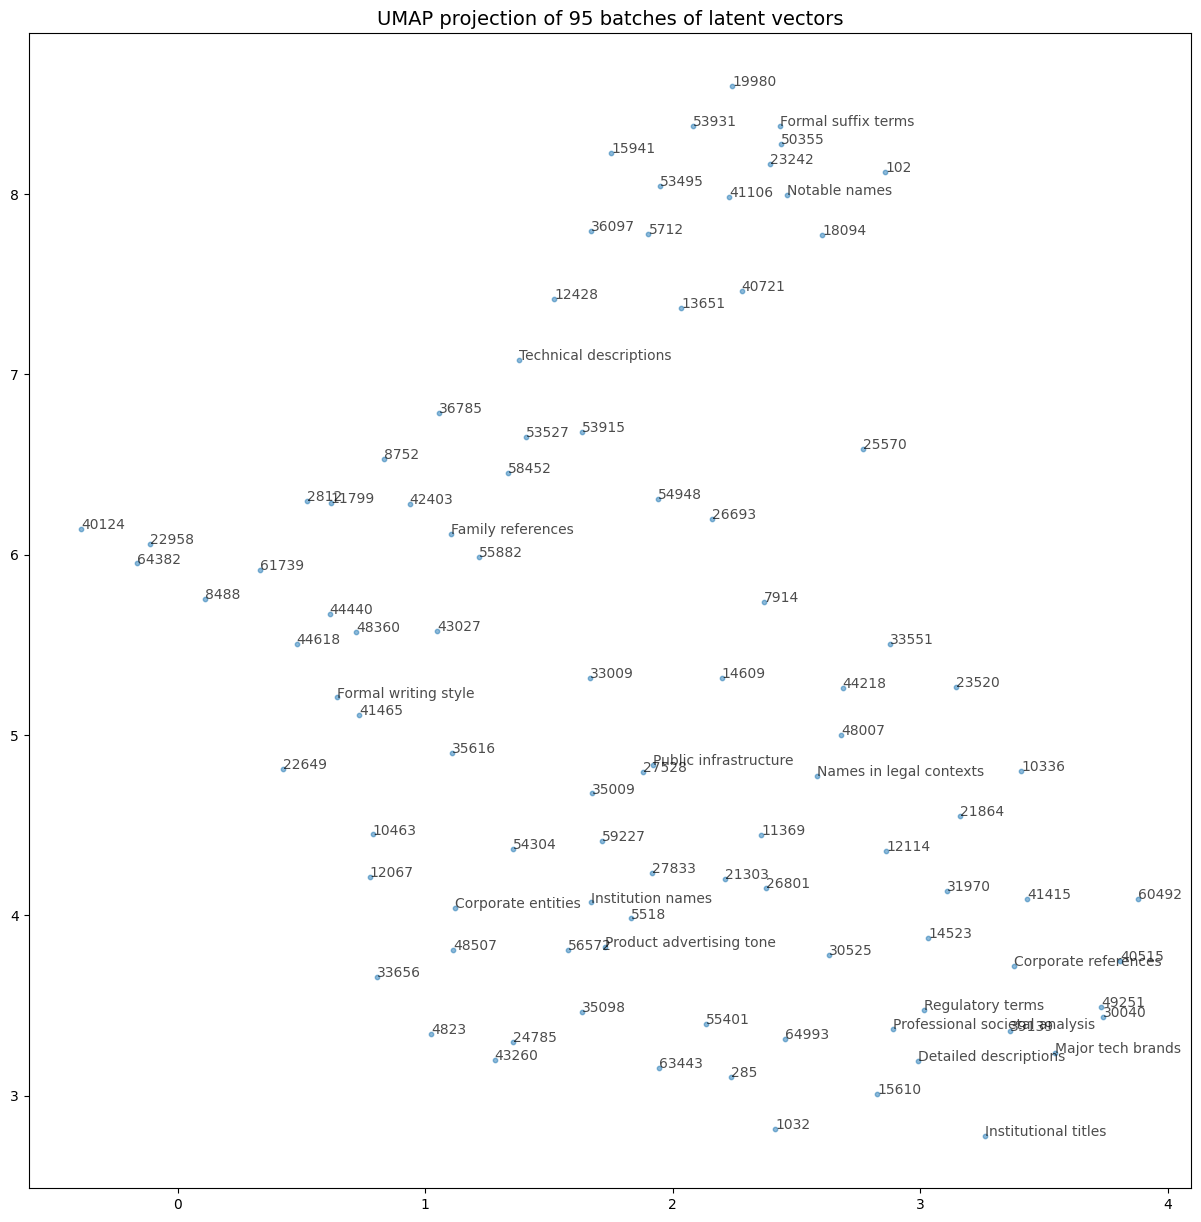

In [5]:

ixs = [12219, 33348, 56081, 48378, 49406, 60636, 50974, 17505, 1594, 57862, 7914, 40773, 60113,
 36097, 61739, 40515, 23242, 19980, 102, 44440, 31970, 53915, 50355, 42403, 41106, 2812, 36770, 35616,
 27833, 35098, 48360, 11369, 35009, 40721, 33551, 10336, 27528, 18094, 64382, 14609, 59227, 33009,
 22958, 21864, 26801, 60492, 33656, 48507, 12114, 8488, 1032, 25570, 5518, 41465, 58452, 11799,
 53527, 26536, 48007, 22649, 12428, 43027, 49251, 44218, 8752, 30040, 63443, 285, 39139, 36785,
 15941, 23520, 14523, 21303, 45157, 55401, 30525, 53495, 53931, 4823, 55882, 64993, 43260,
 15610, 54948, 40124, 56572, 26693, 44618, 12067, 41415, 24785, 5712, 23393, 54304, 10463,
 13651, 31034, 32965, 55900]
feature_names = {
    50974: 'Detailed descriptions',
    23393: 'Public infrastructure',
    33348: 'Institution names',
    12219: 'Corporate entities',
    36770: 'Professional societal analysis',
    26536: 'Product advertising tone',
    45157: 'Institutional titles',
    56081: 'Major tech brands',
    48378: 'Notable names',
    49406: 'Technical descriptions',
    60636: 'Family references',
    17505: 'Formal writing style',
    1594: 'Names in legal contexts',
    57862: 'Regulatory terms',
    40773: 'Formal suffix terms',
    60113: 'Corporate references'
}
plot_UMAP(ixs, feature_names, latent_vector_files, save_path=None)